In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/tlink_data"

train_X_tlink.npy  train_Y_tlink.npy


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [0]:
#load data
features = np.load("/content/drive/My Drive/tlink_data/train_X_tlink.npy")
label = np.load("/content/drive/My Drive/tlink_data/train_Y_tlink.npy")

In [0]:
#label = np.resize(label, (label.shape[0], 1))
print(features.shape)
print(label.shape)
print(np.sum(label))

(587842, 13)
(587842,)
128300


In [0]:
features = features.astype('float32')
label = label.astype('float32')

In [0]:
import torch.utils.data
X_train = torch.from_numpy(features)
Y_train = torch.from_numpy(label)

train = torch.utils.data.TensorDataset(X_train,Y_train)

train_loader = torch.utils.data.DataLoader(train, batch_size = 65536, shuffle = False)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
# Network architecture

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

net = Net()
print(device)
net.to(device)

cuda:0


Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

In [0]:
# training
def train(net, initial_lr = 0.0005):
  
  import torch.optim as optim
  criterion = torch.nn.BCELoss()
  optimizer = optim.Adam(net.parameters(), lr=initial_lr)

  def lr_scheduler(optimizer, epoch, lr_init=initial_lr):
    """Decay learning rate by a factor of (1/(epoch^0.1)) every lr_decay_epoch epochs."""
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = (lr_init)/(np.power(epoch+1, 0.1))
        
    return optimizer
  
  
  lossList = []
  for epoch in range(250):  # loop over the dataset multiple times
      running_loss = 0.0
      count = 0


      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, groundtruth = data[0].to(device), data[1].to(device)
          #inputs, groundtruth = data
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = net(inputs.float())
          outputs = outputs.reshape(groundtruth.shape)
          loss = criterion(outputs, groundtruth)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          count += 1


      #change learning rate
      optimizer = lr_scheduler(optimizer, epoch)
      print(str(epoch)+": "+str(running_loss/count))
      lossList.append(running_loss/count)
      
  #plot learning curve
  epoch_count = range(1, epoch+2)
  plt.plot(epoch_count, lossList, 'b-')
  plt.title('Learning Curve')
  plt.ylabel('Loss')
  plt.xlabel('Iteration')
  plt.legend(['Training Loss'])
  plt.show()
  print('Finished Training')
  return net

0: 0.6851074364450243
1: 0.6452042327986823
2: 0.610327316655053
3: 0.5825786855485704
4: 0.5611624783939786
5: 0.5454881919754876
6: 0.5347069501876831
7: 0.5276482767528958
8: 0.5233298871252272
9: 0.5205996831258138
10: 0.5173929929733276
11: 0.5147686766253577
12: 0.5125238200028738
13: 0.5099024971326193
14: 0.5069548189640045
15: 0.503703213400311
16: 0.5001132057772743
17: 0.49620164765252006
18: 0.4919910530249278
19: 0.48748891883426243
20: 0.4827088514963786
21: 0.47768543163935345
22: 0.4724861416551802
23: 0.46721087561713326
24: 0.46196940872404313
25: 0.45685119761361015
26: 0.4518816437986162
27: 0.4470272759596507
28: 0.44217999113930595
29: 0.43742431534661186
30: 0.4332965645525191
31: 0.42937233050664264
32: 0.4255939523379008
33: 0.4219241572750939
34: 0.4183644453684489
35: 0.4148688316345215
36: 0.4114493595229255
37: 0.40810361835691666
38: 0.4047969612810347
39: 0.4014592733648088
40: 0.3981086048814986
41: 0.39484602212905884
42: 0.39151255951987374
43: 0.38792

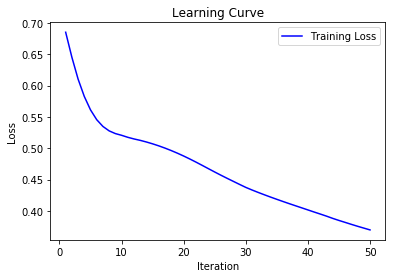

Finished Training


In [0]:
net = train(net, 0.0005)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_50.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_50.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.3673288855287764
1: 0.3647850983672672
2: 0.36200829678111607
3: 0.3598915768994225
4: 0.35801268617312115
5: 0.35622607005967033
6: 0.35468634963035583
7: 0.3531975613700019
8: 0.3518349296516842
9: 0.3506090044975281
10: 0.3495280212826199
11: 0.34856463472048443
12: 0.3476671344704098
13: 0.3468359344535404
14: 0.3460566500822703
15: 0.345324887169732
16: 0.344631165266037
17: 0.34397093454996747
18: 0.3433419068654378
19: 0.3427402211560143
20: 0.3421619070900811
21: 0.341602881749471
22: 0.34106043974558514
23: 0.3405316107802921
24: 0.3400147027439541
25: 0.3395100732644399
26: 0.339015930891037
27: 0.33853088153733146
28: 0.338054574198193
29: 0.3375866346889072
30: 0.3371262318558163
31: 0.3366724020904965
32: 0.3362244698736403
33: 0.3357817166381412
34: 0.335343556271659
35: 0.33490948213471305
36: 0.33447903725836015
37: 0.33405180441008675
38: 0.33362746238708496
39: 0.33320549461576676
40: 0.3327854971090953
41: 0.33236778444714016
42: 0.33195270432366264
43: 0.331539

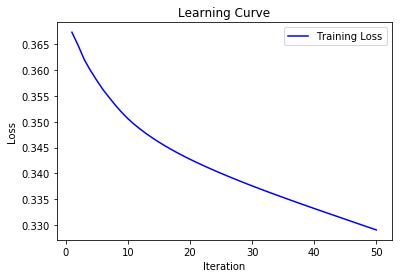

Finished Training


In [0]:
net = train(net, 0.00035)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_100.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_100.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.3291948172781203
1: 0.3291075925032298
2: 0.3277181188265483
3: 0.3276394108931224
4: 0.32698814736472237
5: 0.32658838232358295
6: 0.32623233066664803
7: 0.32578586869769627
8: 0.325434856944614
9: 0.32502082652515835
10: 0.32464510202407837
11: 0.3242597248819139
12: 0.3238718609015147
13: 0.32349040110905963
14: 0.32309655017322964
15: 0.32268843717045254
16: 0.32227423124843174
17: 0.32187265157699585
18: 0.3214734395345052
19: 0.32107189297676086
20: 0.32066960798369515
21: 0.32027096880806816
22: 0.3198810915152232
23: 0.3195023900932736
24: 0.31913435128000045
25: 0.3187748822900984
26: 0.3184219499429067
27: 0.31807422306802535
28: 0.31773093342781067
29: 0.3173915677600437
30: 0.31705567902988857
31: 0.31672293278906083
32: 0.3163930806848738
33: 0.3160659571488698
34: 0.3157413899898529
35: 0.315419336160024
36: 0.31509968969557023
37: 0.3147824505964915
38: 0.3144675526354048
39: 0.3141549593872494
40: 0.3138446509838104
41: 0.313536587688658
42: 0.3132307728131612
43: 

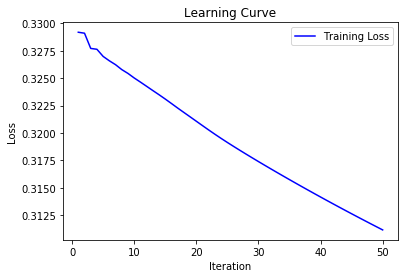

Finished Training


In [0]:
net = train(net, 0.0003)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_150.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_150.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.3115031917889913
1: 0.3111078441143036
2: 0.3102683656745487
3: 0.3100426130824619
4: 0.3097156253125932
5: 0.3093628552224901
6: 0.30913302302360535
7: 0.3088282015588548
8: 0.308566411336263
9: 0.30829458435376483
10: 0.30802968475553727
11: 0.30777360995610553
12: 0.30751345886124504
13: 0.30726122856140137
14: 0.3070093227757348
15: 0.3067589865790473
16: 0.306510051091512
17: 0.3062602116001977
18: 0.30601117346021867
19: 0.30576343337694806
20: 0.3055192530155182
21: 0.30527885754903156
22: 0.30504267414410907
23: 0.3048100305928124
24: 0.3045787579483456
25: 0.30434821049372357
26: 0.3041178418530358
27: 0.30388544996579486
28: 0.303650160630544
29: 0.30341058638360763
30: 0.3031788302792443
31: 0.30295321014192367
32: 0.3027230269379086
33: 0.3024883204036289
34: 0.3022533357143402
35: 0.30202483799722457
36: 0.30180208219422233
37: 0.3015829589631822
38: 0.3013644615809123
39: 0.30114657017919755
40: 0.30093537436591256
41: 0.30072731110784745
42: 0.30051964190271163
43: 

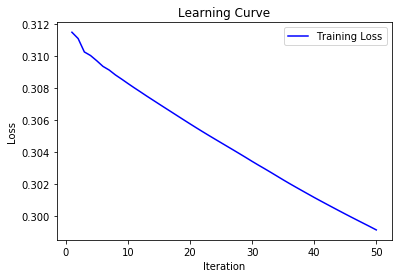

Finished Training


In [0]:
net = train(net, 0.00025)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_200.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_200.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.2995103928777907
1: 0.2990546656979455
2: 0.29857798748546177
3: 0.29834416177537704
4: 0.2982264326678382
5: 0.29795992374420166
6: 0.29782259795400834
7: 0.29765794343418545
8: 0.29748619265026516
9: 0.297336694267061
10: 0.29717093374994064
11: 0.2970112595293257
12: 0.29685406552420723
13: 0.2966936363114251
14: 0.2965375516149733
15: 0.29638445377349854
16: 0.2962336838245392
17: 0.2960858974191878
18: 0.2959398561053806
19: 0.29579543073972064
20: 0.2956526577472687
21: 0.2955111298296187
22: 0.2953698999351925
23: 0.29522807399431866
24: 0.29508646329243976
25: 0.2949478262000614
26: 0.29481494426727295
27: 0.2946854531764984
28: 0.29455650846163434
29: 0.29442644450399613
30: 0.29429302944077385
31: 0.29415450824631584
32: 0.29401202003161114
33: 0.2938719689846039
34: 0.2937357955508762
35: 0.2936055428451962
36: 0.29348084330558777
37: 0.2933605478869544
38: 0.2932425406244066
39: 0.29312530491087174
40: 0.2930086851119995
41: 0.2928927209642198
42: 0.2927774058447944
43

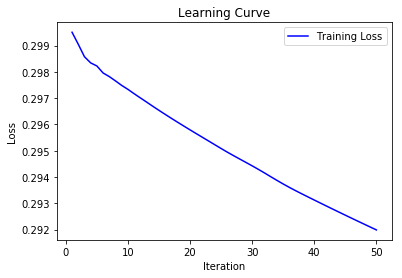

Finished Training


In [0]:
net = train(net, 0.0002)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_250.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_250.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.29253894752926296
1: 0.29221073124143815
2: 0.29169506827990216
3: 0.29148734940422905
4: 0.29144712620311314
5: 0.2912047836515639
6: 0.2911226020918952
7: 0.29099662105242413
8: 0.29085777865515816
9: 0.29075151681900024
10: 0.290624909930759
11: 0.2905060549577077
12: 0.29039206107457477
13: 0.29027379552523297
14: 0.2901595930258433
15: 0.29004594021373326
16: 0.2899322940243615
17: 0.2898203366332584
18: 0.2897088560793135
19: 0.2895980411105686
20: 0.2894880937205421
21: 0.28937869601779515
22: 0.28926992416381836
23: 0.2891617914040883
24: 0.28905416859520805
25: 0.28894709216223824
26: 0.28884051243464154
27: 0.2887344029214647
28: 0.28862877355681527
29: 0.2885235614246792
30: 0.28841881619559395
31: 0.28831444183985394
32: 0.2882104648484124
33: 0.28810687197579277
34: 0.28800363341967267
35: 0.2879007293118371
36: 0.2877981662750244
37: 0.28769586814774406
38: 0.28759391440285575
39: 0.28749218583106995
40: 0.287390755282508
41: 0.2872895366615719
42: 0.287188536591
43:

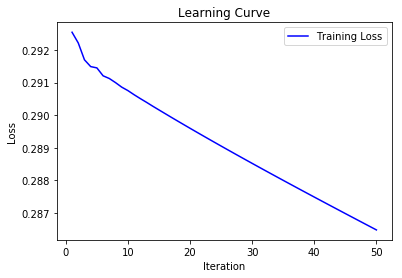

Finished Training


In [0]:
net = train(net, 0.0002)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_300.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_300.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.28707509570651585
1: 0.2868378923998939
2: 0.2862134145365821
3: 0.2860320740275913
4: 0.28599466549025643
5: 0.2857481274339888
6: 0.28569537070062423
7: 0.28556555178430343
8: 0.2854373918639289
9: 0.2853403819931878
10: 0.2852175599998898
11: 0.28510844376352096
12: 0.28499997986687553
13: 0.28488727410634357
14: 0.28477950228585136
15: 0.28467080659336513
16: 0.2845624519719018
17: 0.28445553448465133
18: 0.28434861699740094
19: 0.2842425008614858
20: 0.2841370039516025
21: 0.28403197394477
22: 0.2839275896549225
23: 0.283823698759079
24: 0.28372030125723946
25: 0.2836173441674974
26: 0.2835147711965773
27: 0.28341249293751186
28: 0.2833104862107171
29: 0.2832086847888099
30: 0.283107019133038
31: 0.2830054329501258
32: 0.28290389974912006
33: 0.28280235330263775
34: 0.2827008002334171
35: 0.28259916437996757
36: 0.28249746892187333
37: 0.2823957171705034
38: 0.2822939025031196
39: 0.2821920845243666
40: 0.2820902367432912
41: 0.2819884220759074
42: 0.28188667363590664
43: 0.2

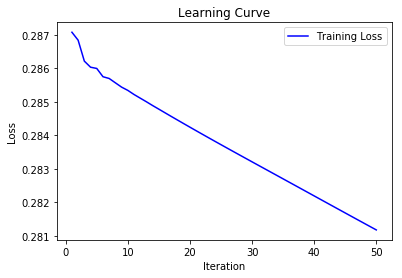

Finished Training


In [0]:
net = train(net, 0.0002)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_350.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
net = torch.load('/content/drive/My Drive/tlink_data/t_model_350.pt')
net.eval()

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

0: 0.2815048330359989
1: 0.2809203002187941
2: 0.28099700808525085
3: 0.2807939913537767
4: 0.2806946370336745
5: 0.2806787888209025
6: 0.2806086175971561
7: 0.28052960170639885
8: 0.28047550717989606
9: 0.280422654416826
10: 0.2803616159492069
11: 0.28030265702141655
12: 0.28024739358160233
13: 0.2801915638976627
14: 0.28013524744245744
15: 0.2800799575116899
16: 0.28002538283665973
17: 0.2799709737300873
18: 0.2799168560240004
19: 0.27986318204138017
20: 0.2798098888662126
21: 0.2797568705346849
22: 0.27970416016048855
23: 0.27965174780951607
24: 0.2795996334817674
25: 0.27954777744081283
26: 0.2794961796866523
27: 0.2794448600875007
28: 0.2793937590387132
29: 0.2793429394563039
30: 0.2792923284901513
31: 0.2792419460084703
32: 0.2791917820771535
33: 0.2791418466303084
34: 0.27909211979971993
35: 0.2790425916512807
36: 0.27899327543046737
37: 0.278944151269065
38: 0.2788952092329661
39: 0.27884649236996967
40: 0.278797941075431
41: 0.2787495619720883
42: 0.27870138817363316
43: 0.278

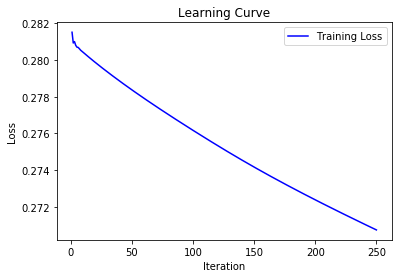

Finished Training


In [0]:
net = train(net, 0.0001)

In [0]:
torch.save(net, '/content/drive/My Drive/tlink_data/t_model_600.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
